In [7]:
import torch
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader
import numpy as np

# pyplot
import matplotlib.pyplot as plt

import torch.nn as nn
import torch

MNIST DATASET PREPERATION

In [8]:
class Noisy_MNIST(Dataset):
    # initialization of the dataset
    def __init__(self, split, data_loc, noise=0.5):
        # save the input parameters
        self.split    = split 
        self.data_loc = data_loc
        self.noise    = noise
        
        if self.split == 'train':
            Train = True
        else:
            Train = False
            
        # get the original MNIST dataset   
        Clean_MNIST = datasets.MNIST(self.data_loc, train=Train, download=True)
        
        # reshuffle the test set to have digits 0-9 at the start
        if self.split == 'train':
            data = Clean_MNIST.data.unsqueeze(1)
        else:
            data = Clean_MNIST.data.unsqueeze(1)
            idx = torch.load('test_idx.tar')
            data[:,:] = data[idx,:]
            
        
        # reshape and normalize
        resizer = transforms.Resize(32)
        resized_data = resizer(data)*1.0
        normalized_data = 2 *(resized_data/255) - 1
        #normalized_data = (resized_data - 33)/74
        
        # create the data
        self.Clean_Images = normalized_data
        self.Noisy_Images = normalized_data + torch.randn(normalized_data.size())*self.noise
        self.Labels       = Clean_MNIST.targets
    
    # return the number of examples in this dataset
    def __len__(self):
        return self.Labels.size(0)
    
    # create a a method that retrieves a single item form the dataset
    def __getitem__(self, idx):
        clean_image = self.Clean_Images[idx,:,:,:]
        noisy_image = self.Noisy_Images[idx,:,:,:]
        label =  self.Labels[idx]
        
        return clean_image,noisy_image,label

In [9]:
# %% dataloader for the Noisy MNIST dataset
def create_dataloaders(data_loc, batch_size):
    Noisy_MNIST_train = Noisy_MNIST("train", data_loc)
    Noisy_MNIST_test  = Noisy_MNIST("test" , data_loc)
    
    Noisy_MNIST_train_loader =  DataLoader(Noisy_MNIST_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Noisy_MNIST_test_loader  =  DataLoader(Noisy_MNIST_test , batch_size=batch_size, shuffle=False, drop_last=False)
    
    return Noisy_MNIST_train_loader, Noisy_MNIST_test_loader

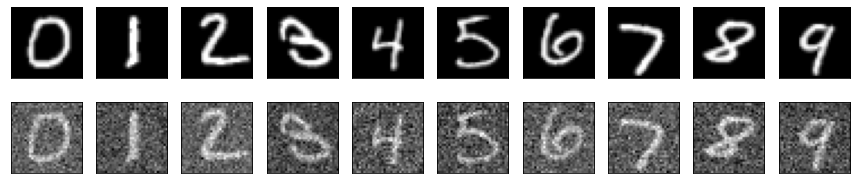

In [10]:
# define parameters
data_loc = 'MNIST Datasets' #change the datalocation to something that works for you
batch_size = 64

# get dataloader
train_loader, test_loader = create_dataloaders(data_loc, batch_size)

# get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
# use these example images througout the assignment as the first 10 correspond to the digits 0-9

# show the examples in a plot
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

EXERCISE 1A

In [11]:
def soft_threshold(x, Lambda):
    return np.sign(x) * np.maximum(np.abs(x) - Lambda, 1)

def ISTA(mu, Lambda, K, y):
    x = np.zeros((y.shape[0], y.shape[1]))
    A = np.identity(y.shape[0])
    for _ in range(K):
        x = soft_threshold(x + (mu*(2*np.dot(A.T, y - A.dot(x)))), Lambda)
    return x 

In [12]:
noisy_measurements = x_noisy_example[0:10,0,:,:].numpy() 
noisy_measurements = np.reshape(noisy_measurements, (noisy_measurements.shape[0], 1024))    # flatten the input

# Parameter values for ISTA
mu = 0.001
Lambda = 1
K = 10

reconstructed_x = ISTA(mu, Lambda, K, noisy_measurements)

EXERCISE 1B



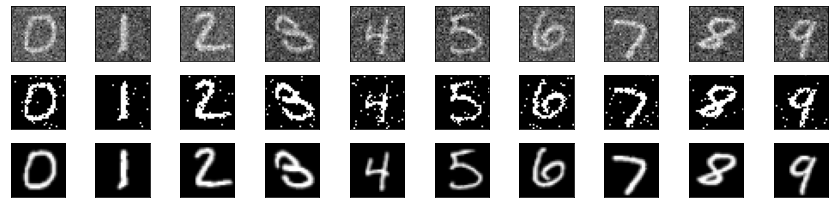

In [13]:
# show the examples in a plot
reconstructed_x = np.reshape(reconstructed_x, (reconstructed_x.shape[0], 1, 32, 32))

plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(x_noisy_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 10, i+11)
    plt.imshow(reconstructed_x[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3, 10, i+21)
    plt.imshow(x_clean_example[i,0,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png", dpi=100, bbox_inches='tight')
plt.show()

EXERCISE 1C

In [173]:
# Creating the test set and train set
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

In [184]:
# Converting the tensor to numpy array of size N x 1024
x_noisy_test_flatten = x_noisy_test.numpy() 
x_noisy_test_flatten = np.reshape(x_noisy_test_flatten, (x_noisy_test_flatten.shape[0],1024))
reconstructed_x_test = ISTA(mu, Lambda, K, x_noisy_test_flatten)

# Calculating MSE Loss
mse_loss = nn.MSELoss()
reconstructed_x_test = np.reshape(reconstructed_x_test, (reconstructed_x_test.shape[0], 1, 32, 32))
rec_x_test_tensor = torch.tensor(reconstructed_x_test)
loss = mse_loss(rec_x_test_tensor, x_clean_test)
print('MSE loss for ISTA is', loss.numpy())


MSE loss for ISTA is 0.16947324511739248
